# Correlation of Continuous and Categorical Injury Risk Predictors

## Introduction

When constructing linear models, it is advisable to avoid using highly correlated predictors. If correlated predictors are entered into a linear model [then variance will increase](https://towardsdatascience.com/why-exclude-highly-correlated-features-when-building-regression-model-34d77a90ea8e).

Correlation between two continuous measures is taught universally to students of statistics (R-squared, or the Pearson's Correlation Factor). In practice, however, datasets often contain a mix of continous and categorical variables.

The purpose of this notebook is to demonstrate some methods to judge correlation between a mixure of continuous and categorical variables. The two measures will be Cramer's V statistics for categorical-categorical comparisons and the Kruskal-Wallis H test for continuous-categorical comparisons. A more detailed discussion on correlation measures for categorical and continuous variables can be found [here](https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

%matplotlib inline

## Data

The dataset used will be from real-world traffic crashes (NASS/CDS) from [this paper](https://doi.org/10.1080/15389588.2014.927577). The dataset contains information from vehicles involved in crashes. The following tabel describes the variables of interest. All variables except `log_deltaV` are categorical.

| Variable            | Description                                              |
|---------------------|----------------------------------------------------------|
| log_deltaV          | Logarithm of change in velocity of crash (mph)           |
| GAD                 | General area of damage (1=Front, 2=Right, 3=Left, 4=Back)|
| all_belted          | Driver and right front passenger were belted (1=Yes, 0=No)|
| body_type           | Vehicle type (1=Car, 2=SUV, 3=Van, 4=Pickup)             |
| multiple_events     | Vehicle experience more than 1 crash (1=Yes, 0=No)       |
| veh55_or_older      | At least one occupant is 55 years or older (1=Yes, 0=No) |
| veh_all_male        | All occupants are male (1=Yes, 0=No)                     |

In [2]:
df = pd.read_csv('AACN_dataset.csv')
x_vars = ['log_deltaV', 'GAD', 'all_belted', 'body_type', 'multiple_events', 'veh55_or_older', 'veh_all_male']

The dataset contains multiple years of crashes from 2004 to 2011. To reduce variance that might be introduced due to changing vehicle fleets over time (e.g., seat belt use), we will restrict the data to the last 2 years of data

In [3]:
df['caseyear'].value_counts()

2004    2232
2003    1912
2008    1901
2006    1892
2002    1841
2005    1788
2007    1696
2009    1198
2010    1012
2011     926
Name: caseyear, dtype: int64

In [4]:
df = df.loc[df['caseyear'].isin([2011, 2010]), :]
len(df)

1938

## Analysis Method

One common way to visualize correlation between variables is a Pair-plot where a matrix of plots is created each comparing 2 variables. The seaborn library for python contains the `pairplot` functions that will do this. As discussed previously, these analyses are often focused on categorical-to-categorical comparisons. Therefore, the Seaborn `pairplot` function doesn't work so well when categorical variables are in the data. So, we will use Seaborn's `PairGrid` class to create a custom pairplot. The `PairGrid` class allows the user to specify custom plotting functions for diagonal and upper/lower cells of the matrix. We will focus on the upper diagonal as the lower diagonal is just a reflection.

In [5]:
def plot_pairs(x, y, **kwargs):
    """
    Plotting function for PairGrid off-diagonals containing categorical and continuous measures

    Here we assume only the upper diagonal is used.
    As a heuristic, we assume any series with more than 10 unique values is continuous.
    """
    # when used with the "hue" argument of PairGrid,
    # there may be 1 or more classes passed in.
    try:
        classid = float(kwargs['label'])
    except ValueError:
        classid = 0.0
    # hacky-hack to pass to plotting functions
    kwargs['classid'] = classid

    max_categories = 10

    if len(y.unique()) > max_categories and \
            len(x.unique()) <= max_categories:
        # categorical x, categorical y
        plot_cont_cat(x, y, **kwargs)
    elif len(x.unique()) > max_categories:
        # unhandeled lower diagonal with 
        pass
    else:
        # categorical-categorical comparison
        plot_cat_cat(x, y, **kwargs)

### Continuous-Categorical Comparison

We will use a Violin plot that is good for visualizing both the density and quantiles of data. The [Kruskal-Wallis H test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) tests whether the median of two or more samples come from the same distribution. If the null hypothesis is rejected (i.e., p < 0.05), then one or more of the different groups has a different mean. The test does not specify which groups are different, just that there is or is not differences (somewhere).

In [6]:
def plot_cont_cat(x, y, **kwargs):
    """
    Violin plot for Continuous-Categorical pair
    """
    ax = plt.gca()
    sns.violinplot(x, y, color=kwargs['color'])

    # Kruskal-Wallis one-way analysis of variance.
    # p < 0.05 ==> groups are correlated
    groups = [y[x == x_cat].to_list() for x_cat in x.unique()]
    k, p = ss.kruskal(*groups)

    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()
    classid = kwargs['classid']
    f_text = 'Kruskal {}: p < {:.3f}'.format(classid, p)
    ax.text(x_lim[0],
            y_lim[1] * 0.8 + 0.1 * classid,
            f_text)

### Categorical-Categorical Comparison

We will just a normalized, stacked bar chart to visualize the cateogorical-categorical pairs. 

In [7]:
def plot_cat_cat(x, y, **kwargs):
    """
    Stacked bar plot for Categorical-Categorical pair with Cramer's V Statistic
    """
    ax = plt.gca()
    classid = kwargs['classid']
    tab = pd.crosstab(x, y)
    cramers_v = cramers_corrected_stat(tab)
    p = pd.crosstab(x, y, normalize=True).plot(ax=ax,
                                               kind='bar',
                                               stacked=True,
                                               width=0.1,
                                               position=classid)
    ax.set_ylim([0, 1])

    # plot cramers v
    xlim = ax.get_xlim()
    yt = 0.8 + classid * 0.1
    ax.text(xlim[0], yt, 'Cramer_v {}: {:.3f}'.format(classid, cramers_v))

A [Cramer's V statistic](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V) with a bias correction was used to judge correlation. Cramer's V goes between 0 and 1. Wikipedia says "\[Cramer's\] V may be viewed as the association between two variables as a percentage of their maximum possible variation". One drawback is that this is just a point estimate and does not have an associated test. The function below was coppied from [this StackOverflow](https://stackoverflow.com/a/39266194) solution.

In [8]:
def cramers_corrected_stat(confusion_matrix):
    """
    calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
    rcorr = r - ((r - 1)**2)/(n - 1)
    kcorr = k - ((k - 1)**2)/(n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

## Results

So much code to visualize! Let's take a look. First we will plot the entire dataset.

The logarithm of the delta-V (top row) is the continuous variable in the dataset. The Kruskal test suggests that general area of damage (GAD) and multiple events are correlated to delta-V. The GAD plot shows frontal damage (GAD = 1) has larger spread and slightly lower median than the other sides. This spread may be due to the fact that rear-end collisions are the dominate crash mode in frontal crashes. These rear-end collisions tend to be lower speed than other crashes. An astute reader may wonder why back damage (GAD = 4) group does not have the same distribution as front damage. As shown in the GAD histogram, there are far fewer back damage crashes because in order to be included in the dataset there can be no missing data from any of the vehicle records. A challenge for the crash reconstructionists in NASS/CDS is locating the crashed vehicles and measuring the damage. It may be that the struck (back damage) vehicle is more often harder to find or measure because there was no damage. If the rear damaged vehicle is severely damaged and thus totaled and easier to find, then it is likely the crash was more severe and the delta-V higher. Although there is some correlation with delta-V, I think GAD should be included in the model. Vehicle crash structure and restrains work very differently depending on the side of the vehicle struck. It would be very surprising if GAD did not correlate with injury outcome.

The delta-V and multiple event correlation is harder to interpret. The distributions look very similar, with multiple events having a slightly longer tail in the low direction. One possible explanation may be that because delta-V in these data is the delta-V from the most harmful event that this most harmful event will be the last event and thus have more time to slow down the vehicle by other means. Like GAD, multiple events may be important to explaining injury risk because in multiple event crashes occupants may be more likely to be out of position and thus have suboptimal interactions with restraints.

For the categorical-categorical pairs, the Cramer's V seems to be low for all except the GAD/multiple event (0.134) and the body type/all male (0.190) pairs. For GAD/multiple events, the proportion of front damage (GAD = 1) in is higher in single event crashes compared to multiple event crashes. My explanation is again the dominance of rear-end collisions in front damage. For the body type/all male pair, the proportion of pickup trucks (body = 4, red bar) in the all male category is higher, which is believable. It also appears the proportion of SUVs (body = 2, orange bar) in not all male is higher than for all male vehicles.

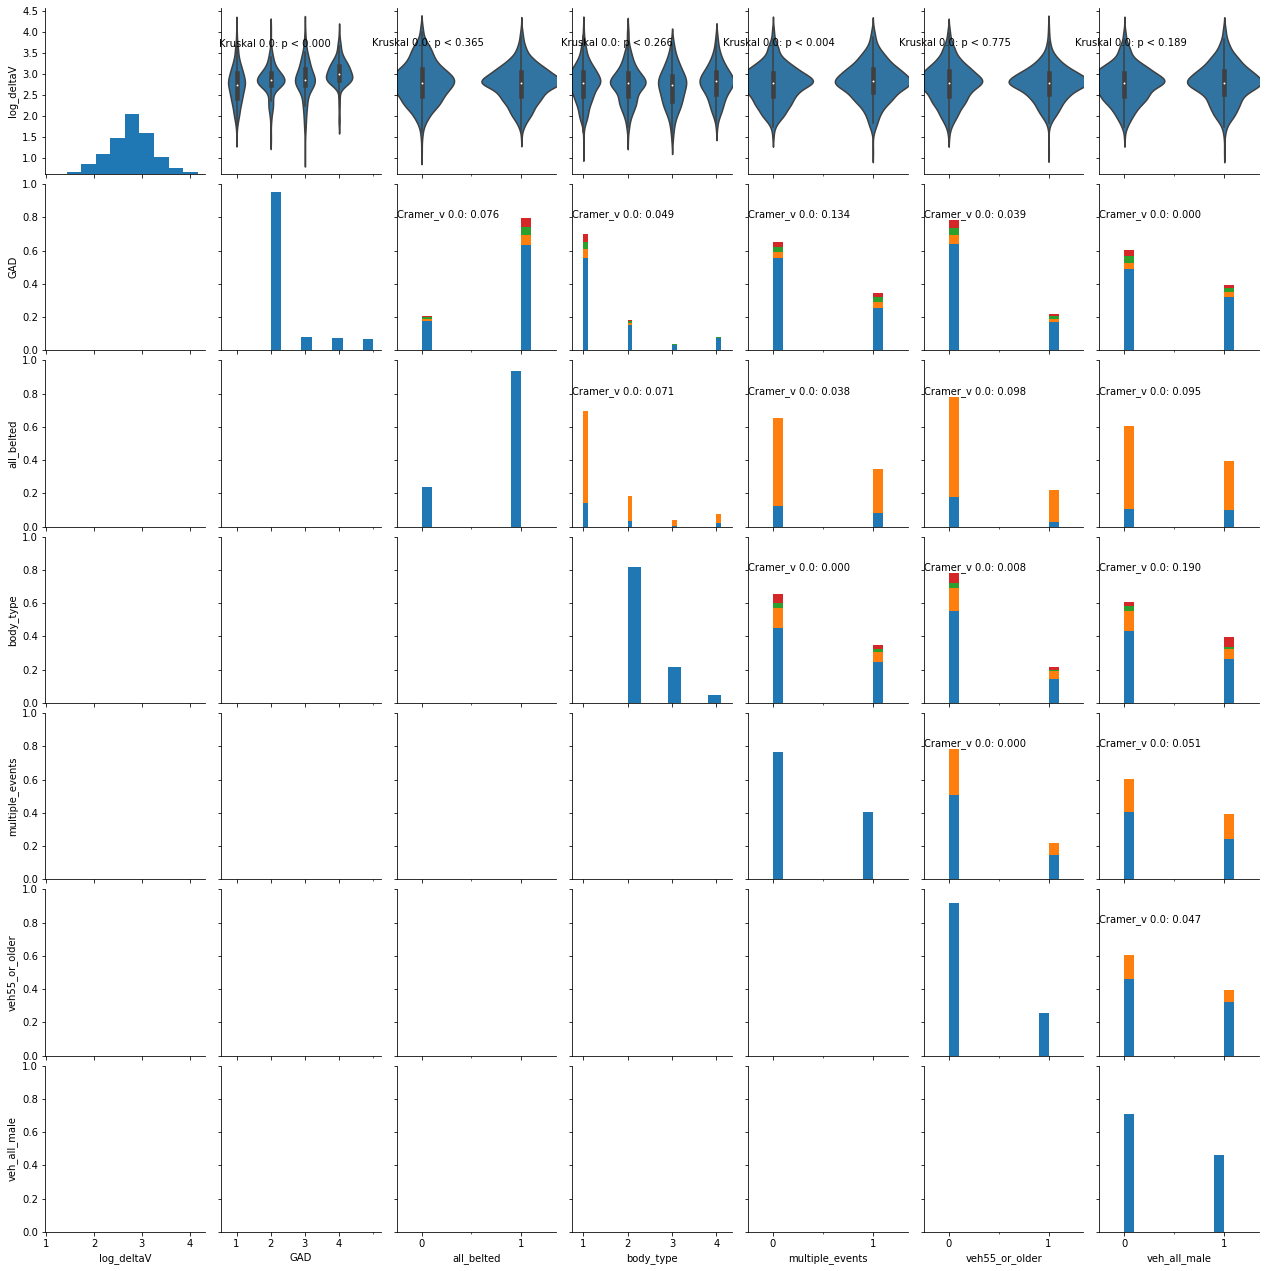

In [9]:
grid = sns.PairGrid(data=df, vars=x_vars)
grid = grid.map_upper(plot_pairs)
grid = grid.map_diag(plt.hist)